# [Chefkoch.de](http://www.chefkoch.de/) Maturaarbeit 2017/18
------

## Ziel: 
### 

In [1]:
%matplotlib inline
import os
import random
import _pickle as pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

predicted hot_pot with probability 0.409
predicted soup_bowl with probability 0.352
predicted corn with probability 0.106
predicted caldron with probability 0.050
predicted consomme with probability 0.031


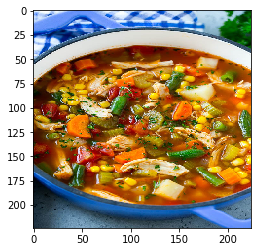

In [37]:
#img, x = get_image("input/images/images/burger.jpg")
img, x = get_image("input/images/images/chicken-vegetable-soup-4.jpg")


predictions = model.predict(x)
imshow(img)
for pred in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred[1], pred[2]))

In [14]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

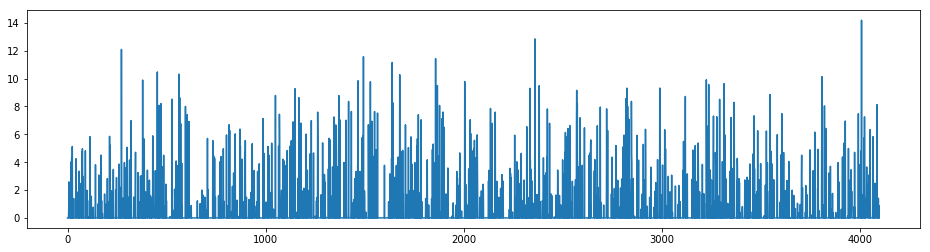

In [15]:
img, x = get_image("input/images/images/burger.jpg")
feat = feat_extractor.predict(x)

matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(feat[0])
matplotlib.pyplot.show()

In [16]:
images_path = './input/images/images/'
max_num_images = 300000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 438 images to analyze


In [17]:
images[:10]

['./input/images/images/vegetable-soup_thecozyapron_1.jpg',
 './input/images/images/images - 2020-05-08T173858.594.jpg',
 './input/images/images/images (61).jpg',
 './input/images/images/images (100).jpg',
 './input/images/images/images - 2020-05-08T173855.825.jpg',
 './input/images/images/images - 2020-05-08T173858.261.jpg',
 './input/images/images/images (52).jpg',
 './input/images/images/images - 2020-05-08T173854.777.jpg',
 './input/images/images/images - 2020-05-08T173852.449.jpg',
 './input/images/images/images - 2020-05-08T173856.918.jpg']

In [9]:
features = []
for image_path in tqdm(images):
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

100%|██████████| 437/437 [02:30<00:00,  2.83it/s]


In [18]:
len(features)

437

In [19]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [20]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'result images')

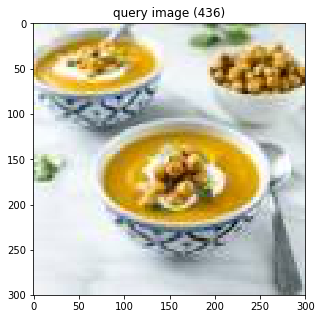

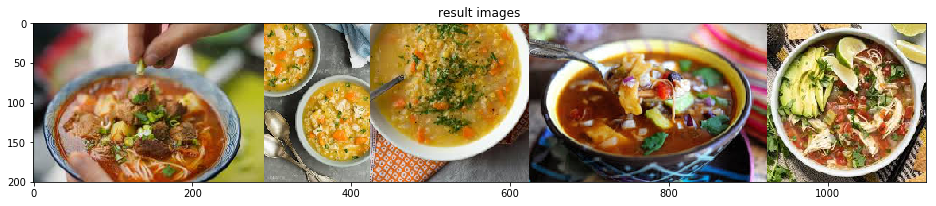

In [21]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)
matplotlib.pyplot.title("result images")

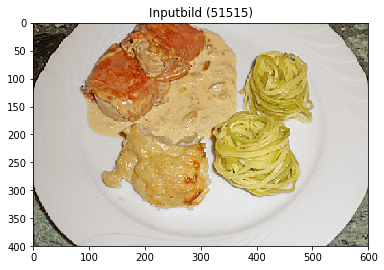

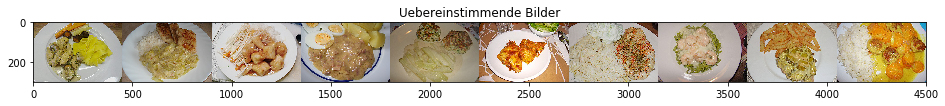

In [27]:
pickle.dump([images, pca_features], open('/output/features_300000_recipes.p', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: '/output/features_300000_recipes.p'

In [28]:
features = np.array(features)
pca2 = PCA(n_components=3)
pca2.fit(features)
pca_features2 = pca2.transform(features)

Text(0.5, 1.0, 'result images')

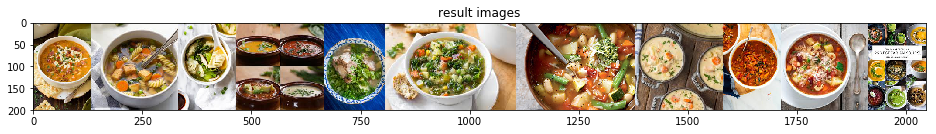

In [29]:
def get_image_path_between(query_image_idx_1, query_image_idx_2, num_hops=4):
    path = [query_image_idx_1, query_image_idx_2]
    for hop in range(num_hops-1):
        t = float(hop+1) / num_hops
        lerp_acts = t * pca_features2[query_image_idx_1] + (1.0-t) * pca_features2[query_image_idx_2]
        distances = [distance.euclidean(lerp_acts, feat) for feat in pca_features2]
        idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])
        path.insert(1, [i for i in idx_closest if i not in path][0])
    return path

# pick image and number of hops
num_hops = 10
query_image_idx_1 = int(len(images) * random.random())
query_image_idx_2 = int(len(images) * random.random())

# get path
path = get_image_path_between(query_image_idx_1, query_image_idx_2, num_hops)

# draw image
path_image = get_concatenated_images(path, 200)
matplotlib.pyplot.figure(figsize = (16,12))
imshow(path_image)
matplotlib.pyplot.title("result images")

# t-SNE Visualisierung

In [30]:
num_images_to_plot = 20000

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(xrange(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [31]:
import json
import matplotlib.pyplot
from PIL import Image
from sklearn.manifold import TSNE

X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 437 samples in 0.006s...
[t-SNE] Computed neighbors for 437 samples in 0.169s...
[t-SNE] Computed conditional probabilities for sample 437 / 437
[t-SNE] Mean sigma: 19.374566
[t-SNE] Computed conditional probabilities in 0.058s
[t-SNE] Iteration 50: error = 80.2901993, gradient norm = 0.4886753 (50 iterations in 0.208s)
[t-SNE] Iteration 100: error = 82.1895676, gradient norm = 0.4380769 (50 iterations in 0.205s)
[t-SNE] Iteration 150: error = 85.7434616, gradient norm = 0.4140613 (50 iterations in 0.217s)
[t-SNE] Iteration 200: error = 84.1355743, gradient norm = 0.4267969 (50 iterations in 0.292s)
[t-SNE] Iteration 250: error = 89.5581589, gradient norm = 0.3942534 (50 iterations in 0.197s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.558159
[t-SNE] Iteration 300: error = 1.7849014, gradient norm = 0.0048493 (50 iterations in 0.231s)
[t-SNE] Iteration 350: error = 1.5572945, gradient norm = 0.0021982 

In [32]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

437it [00:01, 401.52it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/output/tsne/20000-pics-cloud.png'

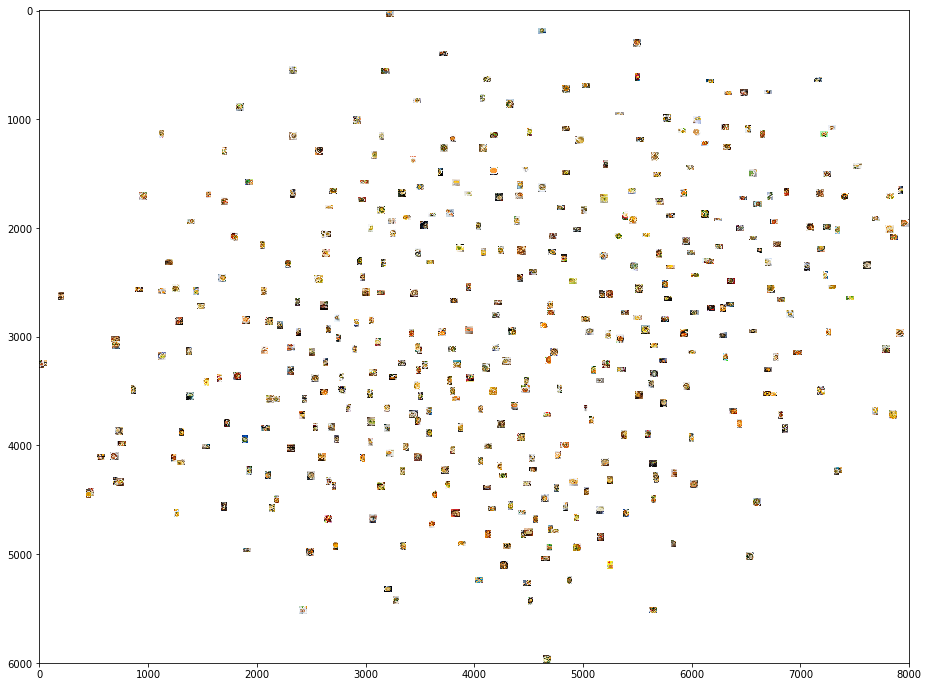

In [34]:
width = 8000
height = 6000
max_dim = 75

full_image = Image.new('RGBA', (width, height))
for img, x, y in tqdm(zip(images, tx, ty)):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)
full_image.save("/output/tsne/20000-pics-cloud.png")

In [ ]:
from IPython.display import Image
PATH = "/Users/Muriz/Desktop/05vis.png"
Image(filename = PATH, width='100%', height=140)

In [ ]:
!git clone https://github.com/Quasimondo/RasterFairy.git

In [ ]:
! pip install ./RasterFairy/.

In [ ]:
import rasterfairy
grid_assignment = rasterfairy.transformPointCloud2D(tsne)

In [ ]:
tile_width = 48
tile_height = 50

full_width = tile_width * 125
full_height = tile_height * 160
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in tqdm(zip(images, grid_assignment[0])):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)
grid_image.save("/output/20000-tSNE-grid-recipes.jpg")

In [ ]:
Image(filename = '/Users/Muriz/Desktop/20000-tSNE-grid-recipes.jpg', width='100%', height=140)